In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from math import sqrt
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [4]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [4]:
# Define the selected exogenous variables and target variable.
features = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]
target = df1['Close']

In [5]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Initialize and fit StandardScalers to scale data using Z-score normalization.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data and transform both training and test data.
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit scaler on training features and transform.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Fit scaler on training target and transform.

# Transform test data without fitting again to avoid data leakage.
X_test_scaled = scaler_X.transform(X_test)  # Transform test features using the scaler fitted on training data.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))  # Transform test target using the scaler fitted on training data.

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Features - Min:", X_train_scaled.min(), "Max:", X_train_scaled.max())
print("Scaled Training Target - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Features - Min:", X_test_scaled.min(), "Max:", X_test_scaled.max())
print("Scaled Test Target - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())


Scaled Training Features - Min: -5.4955652189278625 Max: 9.795796286704956
Scaled Training Target - Min: -3.526234546763028 Max: 2.4845799166596207
Scaled Test Features - Min: -3.5237835824322223 Max: 29.172000533821247
Scaled Test Target - Min: -3.526234546763028 Max: 2.4845799166596207


## Sequence Length = 4 

In [10]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 4  # Number of time steps used for target prediction, 4 weeks.

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (872, 4, 5)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 5)
Reshaped  y_test_seq shape: (151, 1)


### Random Parameters. (Model 1)

In [12]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define hyperparameters
dropout_rate = 0.3          # Dropout rate to help prevent overfitting by randomly dropping nodes during training.
l2_lambda = 0.01            # L2 regularization factor, penalizes large weights and attempt to prevent overfitting.
learning_rate = 0.0002      # Learning rate for the optimizer to control how much to adjust weights during backpropagation.
epochs = 50                 # Maximum number of training epochs.
batch_size = 128            # Batch size for each training step, determines how many samples are used in each gradient update.

# Initialize the LSTM model.
model = Sequential()

# First LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units (neurons) in the layer.
               return_sequences=True,       # Ensures that the layer returns the entire sequence for the next LSTM layer.
               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape: (sequence length, number of features).
               kernel_regularizer=l2(l2_lambda)))  # Applies L2 regularization to reduce overfitting.
model.add(Dropout(dropout_rate))            # Adds dropout layer to reduce overfitting by randomly setting some neurons to 0.

# Second LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units in the second layer.
               return_sequences=False,      # Last LSTM layer should not return sequences; it outputs only the final state.
               kernel_regularizer=l2(l2_lambda)))  # L2 regularization to prevent overfitting.
model.add(Dropout(dropout_rate))            # Dropout for regularization.

# Output layer
model.add(Dense(1))                         # Dense layer with a single unit, since its predicting a single value (regression).

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with a specified learning rate.
              loss='mean_squared_error')                    # Mean Squared Error (MSE) as the loss function for regression.

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',          # Monitor validation loss to stop if it stops improving.
                               patience=10,                 # Wait for 10 epochs with no improvement before stopping.
                               restore_best_weights=True)   # Restore model weights from the epoch with the lowest validation loss.

# Train the model
history = model.fit(X_train_seq, y_train_seq,               # Training data (features and target).
                    epochs=epochs,                          # Maximum number of epochs.
                    batch_size=batch_size,                  # Batch size.
                    validation_data=(X_test_seq, y_test_seq),  # Validation data to monitor overfitting.
                    callbacks=[early_stopping],             # Callback for early stopping. 
                    shuffle=False,
                    verbose=1)                              # Verbose output for progress during training.

# Print final training and validation loss values.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 2.0812 - val_loss: 2.1753
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0504 - val_loss: 2.1441
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0264 - val_loss: 2.1133
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9954 - val_loss: 2.0839
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9676 - val_loss: 2.0555
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9344 - val_loss: 2.0277
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9054 - val_loss: 2.0009
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8793 - val_loss: 1.9751
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8576 - val_loss: 1.9500
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8300 - val_loss: 1.9259
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8045 - val_loss: 1.9022
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7882 - val_loss: 1.8792


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.020287423451894594
Test RMSE: 0.023094093455977842
Training MAE: 0.014687988017215093
Test MAE: 0.01751759367668148
Directional Accuracy on Training Data: 52.81285878300803%
Directional Accuracy on Test Data: 56.666666666666664%


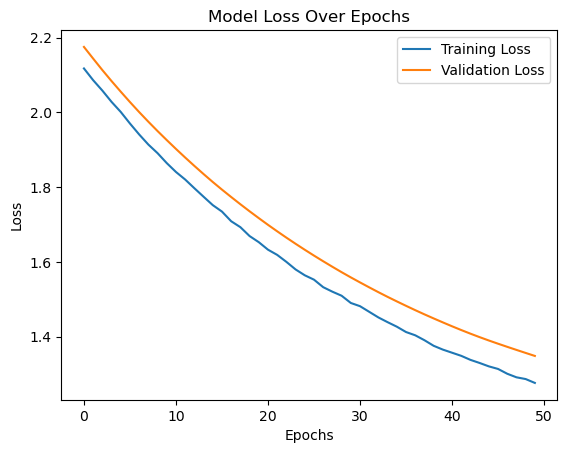

In [13]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2

In [15]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'huber_loss',
    'learning_rate_decay': 1e-6,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 150,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False,
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 3.5201 - val_loss: 1.4710
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.2621 - val_loss: 1.4693
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2747 - val_loss: 1.4705
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0766 - val_loss: 1.4693
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.9527 - val_loss: 1.4722
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7489 - val_loss: 1.4685
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7299 - val_loss: 1.4684
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7223 - val_loss: 1.4653
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6674 - val_loss: 1.4577
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.5854 - val_loss: 1.4552
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.4373 - val_loss: 1.4539
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.0201052013947683
Test RMSE: 0.022911279502954792
Training MAE: 0.014736304543750413
Test MAE: 0.017639764639251702
Directional Accuracy on Training Data: 55.683122847301945%
Directional Accuracy on Test Data: 51.33333333333333%


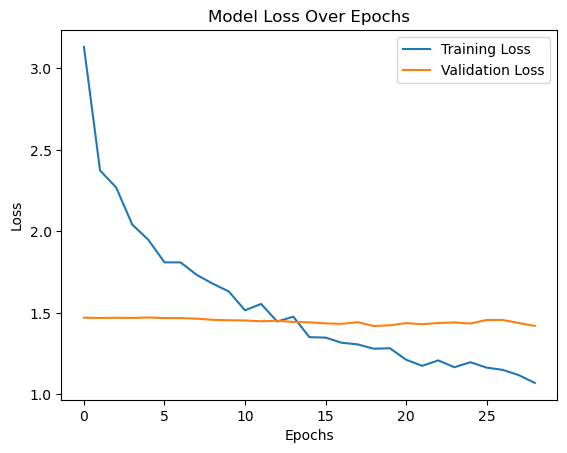

In [16]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1.Random Search 

### Two Layers (Model 3)

In [19]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.5597392320632935
Final Validation Loss: 1.6334689855575562
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.0705389976501465
Final Validation Loss: 2.085648536682129
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.2784720659255981
Final Validation Loss: 1.3736423254013062
Running combination 4

In [19]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 61s 108ms/step - loss: 2.7502 - val_loss: 1.3703
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0192 - val_loss: 1.3694
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7817 - val_loss: 1.3699
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8074 - val_loss: 1.3747
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6046 - val_loss: 1.3705
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6467 - val_loss: 1.3674
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4138 - val_loss: 1.3635
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3351 - val_loss: 1.3573
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2541 - val_loss: 1.3562
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2327 - val_loss: 1.3431
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2408 - val_loss: 1.3438
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
LSTM Model Performance:
Training RMSE: 0.020128678013569528
Test RMSE: 0.022446094508049904
Training MAE: 0.014421071997594166
Test MAE: 0.016954641855865347
Directional Accuracy on Training Data: 62.801377726750864%
Directional Accuracy on Test Data: 59.333333333333336%


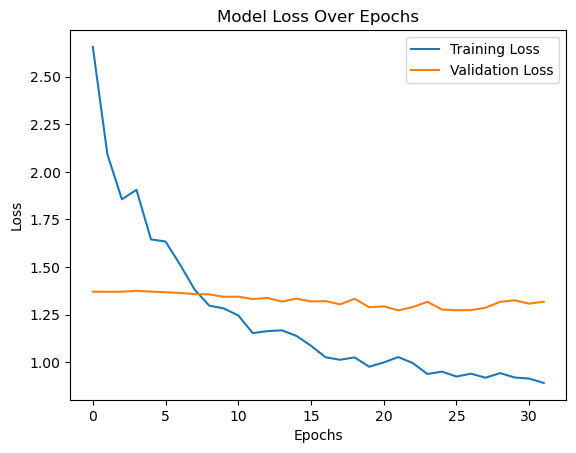

In [20]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 4)

In [23]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0391889810562134
Final Validation Loss: 1.4100106954574585
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.093729496002197
Final Validation Loss: 3.979959487915039
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.6570730209350586
Final Valida

In [24]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 2.8816 - val_loss: 1.2623
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.1265 - val_loss: 1.2615
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.1041 - val_loss: 1.2608
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7166 - val_loss: 1.2599
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.9041 - val_loss: 1.2604
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6197 - val_loss: 1.2601
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7041 - val_loss: 1.2595
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6727 - val_loss: 1.2605
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6655 - val_loss: 1.2619
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6278 - val_loss: 1.2609
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.5656 - val_loss: 1.2630
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.5581 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.019353555449133083
Test RMSE: 0.02264348179826494
Training MAE: 0.013940608013415245
Test MAE: 0.01749623625347844
Directional Accuracy on Training Data: 59.127439724454646%
Directional Accuracy on Test Data: 50.66666666666667%


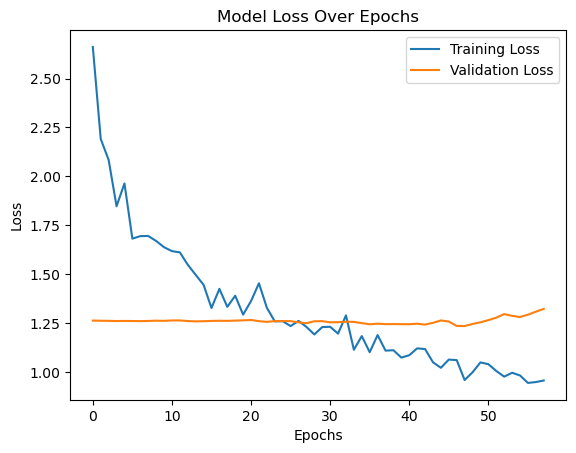

In [25]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 5) 

In [27]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 15:00:59,669] A new study created in memory with name: no-name-794ed8ac-68d6-4dfe-9ed0-bda0cd9b71cf
[I 2024-11-13 15:01:19,373] Trial 0 finished with value: 1.6123017072677612 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6123017072677612.
[I 2024-11-13 15:01:39,131] Trial 1 finished with value: 3.799720525741577 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.6123017072677612.
[I 2024-11-13 15:02:36,053] Trial 2 finished with value: 4.23798942565918 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2,

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.002683355490924503, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.081648588180542


In [27]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.002683355490924503,
    'epochs': 150,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 355ms/step - loss: 2.0148 - val_loss: 1.0927
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4630 - val_loss: 1.0869
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4302 - val_loss: 1.0870
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4546 - val_loss: 1.0881
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2339 - val_loss: 1.0892
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3296 - val_loss: 1.0874
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3421 - val_loss: 1.0867
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1348 - val_loss: 1.0867
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1518 - val_loss: 1.0870
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1346 - val_loss: 1.0864
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1753 - val_loss: 1.0857
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2015 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
LSTM Model Performance:
Training RMSE: 0.020256658930624106
Test RMSE: 0.02298512515860481
Training MAE: 0.014630590368077874
Test MAE: 0.017508579027366036
Directional Accuracy on Training Data: 57.97933409873708%
Directional Accuracy on Test Data: 53.333333333333336%


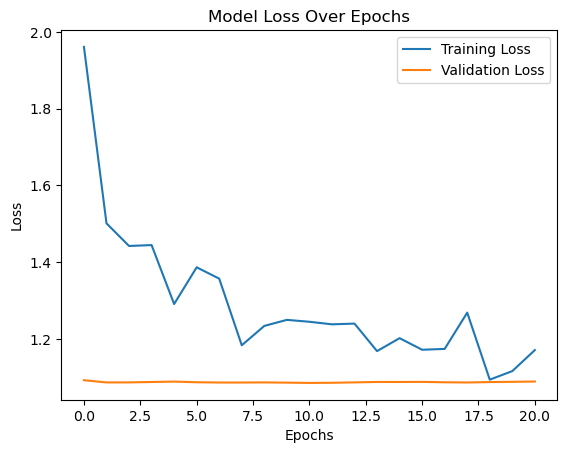

In [28]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 6) 

In [31]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 50s]
val_loss: 1.2762640714645386

Best val_loss So Far: 1.2692660093307495
Total elapsed time: 00h 22m 15s
Built model with params: dropout_rate=0.2, recurrent_dropout=0.1, l2_lambda=0.0848820698329123, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=32
Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0848820698329123, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 32}
Best batch size: 32


In [31]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.0848820698329123,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 105s 289ms/step - loss: 12.7019 - val_loss: 10.1365
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.5374 - val_loss: 9.3764
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.5786 - val_loss: 8.6328
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9777 - val_loss: 7.9604
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0021 - val_loss: 7.3211
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4342 - val_loss: 6.7383
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7950 - val_loss: 6.1781
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2136 - val_loss: 5.6997
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6261 - val_loss: 5.2610
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.1551 - val_loss: 4.8563
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9323 - val_loss: 4.5169
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.020379266382095453
Test RMSE: 0.023003432981341804
Training MAE: 0.014780027591528097
Test MAE: 0.01739230298219025
Directional Accuracy on Training Data: 54.30539609644087%
Directional Accuracy on Test Data: 52.666666666666664%


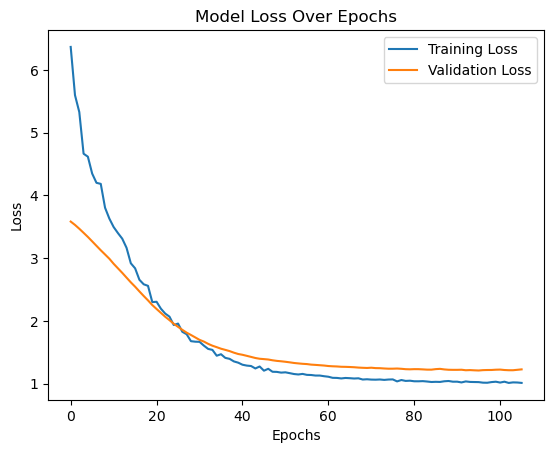

In [33]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation

In [12]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Fold 1 RMSE: 1.3774048906747127
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 RMSE: 0.9408202582049232
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 RMSE: 0.782903270098313
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4 RMSE: 1.092230503404653
Average RMSE from TSCV: 1.0483397305956503


In [13]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
Rolling window RMSE: 1.2032686760193816
Rolling window starting at index 50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/stepWARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023ACB91D3A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Rolling window RMSE: 1.2554291053892312
Rollin

In [14]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.02419945225488671
Descaled Validation Loss: 0.028664543870583613


In [15]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.029496339720642247, 0.02064367803489101, 0.01744158257350905, 0.023713835747330877]
Descaled FRWCV RMSE Values: [0.025965365698812297, 0.02702302691785842, 0.01925909774269816, 0.016311073598994606, 0.016681020330122812, 0.01931634148222494, 0.018284385633828268, 0.011947456879387426, 0.016836374445377993, 0.02289894402031597, 0.028352400854190066]
Average Descaled TSCV RMSE: 0.0228238590190933
Average Descaled FRWCV RMSE: 0.020261407963982816


### Model Performance Metrics for Sequence Length = 4

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       | Model 5       | Model 6       |
|-----------------|---------------|---------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.020287423   | 0.020105201   | 0.020128678   | 0.019353555   | 0.020256659   | 0.020379266   |
| **Test RMSE**  | 0.023094093   | 0.02291128    | 0.022446095   | 0.022643482   | 0.022985125   | 0.023003433   |
| **Train MAE**  | 0.014687988   | 0.014736305   | 0.014421072   | 0.013940608   | 0.01463059    | 0.014780028   |
| **Test MAE**   | 0.017517594   | 0.017639765   | 0.016954642   | 0.017496236   | 0.017508579   | 0.017392303   |
| **Train Loss** | 1.275761962   | 1.070977807   | 0.89046818    | 0.955986023   | 1.171245098   | 0.975797236   |
| **Val Loss**   | 1.34799695    | 1.420421243   | 1.31695807    | 1.321932912   | 1.089339852   | 1.332317114   |
| **Train DA**   | 53%           | 56%           | 63%           | 59%           | 58%           | 54%           |
| **Test DA**    | 57%           | 51%           | 59%           | 51%           | 53%           | 53%           |

**Abreviations:**
- RMSE: Root Mean Squared Error.
- MAE: Mean Absolute Error.
- Loss: Training or Validation Loss.
- DA: Directional Accuracy.
  
---

**The selected model for the sequence length = 4 is the model 3**, The approach had the lowest RMSE, MAE, DA scores.  

#### Training and Validation Loss
| Metric           | Loss           |
|-------------------|----------------|
| **Training Loss** | 0.02419945     |
| **Validation Loss** | 0.02866454    |

#### TSCV RMSE Values
| Fold | RMSE           |
|------|----------------|
| 1    | 0.02949634     |
| 2    | 0.02064368     |
| 3    | 0.01744158     |
| 4    | 0.02371384     |

**Average TSCV RMSE**: **0.02282386**

- The AVG TSCV shows that the model perfoms above the avg in the first and last fold, it could indicate that the folda might contain extreme values, high volatility, extreme events.

#### FRWCV RMSE Values
| Window | RMSE           |
|--------|----------------|
| 1      | 0.02596537     |
| 2      | 0.02702303     |
| 3      | 0.01925910     |
| 4      | 0.01631107     |
| 5      | 0.01668102     |
| 6      | 0.01931634     |
| 7      | 0.01828439     |
| 8      | 0.01194746     |
| 9      | 0.01683637     |
| 10     | 0.02289894     |
| 11     | 0.02835240     |

**Average FRWCV RMSE**: **0.02026141**

- The AVG Fixed Rolling Window CV is 0.020 and the scores points to tha same observations as the TSCV, where the model struggles at the start (1 and 2) and the the end (10 and 11). 

## Sequence Length = 12 

In [17]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 12  # Number of time steps used for target prediction, 12 weeks (Quarterly).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (864, 12, 5)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 5)
Reshaped  y_test_seq shape: (143, 1)


### 1. Random Search (Two Layers - Model 1)

In [39]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.6819857358932495
Final Validation Loss: 1.7873555421829224
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.8224691152572632
Final Validation Loss: 1.943240761756897
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.68576979637146
Final Validation Loss: 1.4648078680038452
Running combination 4/3

In [41]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - loss: 2.9048 - val_loss: 1.3624
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2604 - val_loss: 1.3519
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.0951 - val_loss: 1.3511
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9211 - val_loss: 1.3638
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9609 - val_loss: 1.3514
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6636 - val_loss: 1.3657
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5191 - val_loss: 1.3620
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4354 - val_loss: 1.3926
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3576 - val_loss: 1.4253
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2586 - val_loss: 1.4349
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2539 - val_loss: 1.4581
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step
LSTM Model Performance:
Training RMSE: 0.02035712755808831
Test RMSE: 0.02325925288336113
Training MAE: 0.014789920264741121
Test MAE: 0.01750357412587093
Directional Accuracy on Training Data: 56.89455388180765%
Directional Accuracy on Test Data: 61.267605633802816%


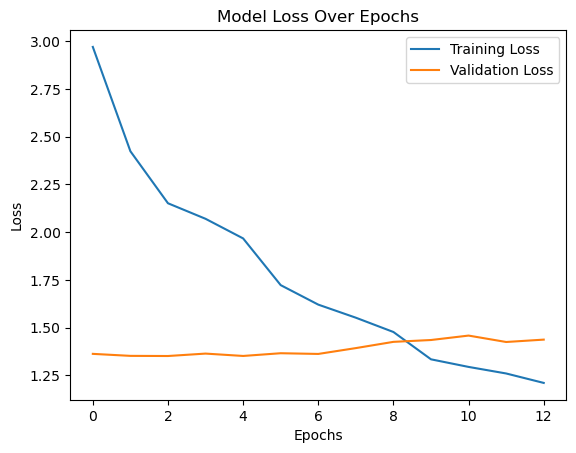

In [42]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [43]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.097215175628662
Final Validation Loss: 1.6395092010498047
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.121798038482666
Final Validation Loss: 4.114628791809082
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.1874756813049316
Final Validat

In [45]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 2.9335 - val_loss: 1.2980
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.0785 - val_loss: 1.2945
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.8619 - val_loss: 1.2904
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.8648 - val_loss: 1.2911
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.9126 - val_loss: 1.2890
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.6924 - val_loss: 1.2977
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7158 - val_loss: 1.2987
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.8382 - val_loss: 1.2919
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.5821 - val_loss: 1.2866
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.6577 - val_loss: 1.2891
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.5682 - val_loss: 1.2838
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.5881 - val_los

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 
LSTM Model Performance:
Training RMSE: 0.020397132148614005
Test RMSE: 0.023255508587434307
Training MAE: 0.01468457066101824
Test MAE: 0.017394277378284455
Directional Accuracy on Training Data: 51.680185399768256%
Directional Accuracy on Test Data: 47.88732394366197%


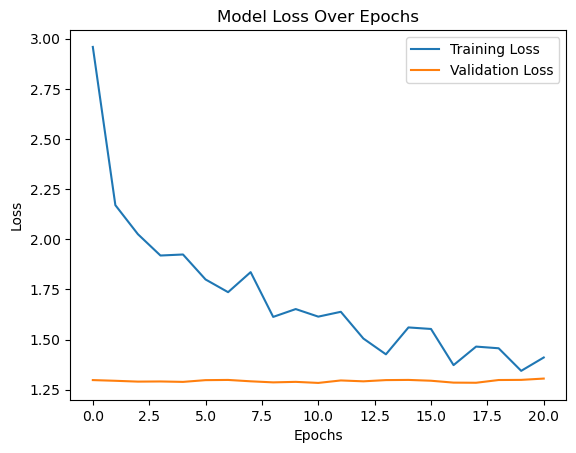

In [46]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [47]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 15:56:55,726] A new study created in memory with name: no-name-ff174d5d-984e-4aed-b1ba-6af0b08cd6b7
[I 2024-11-13 15:57:17,507] Trial 0 finished with value: 1.6623047590255737 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6623047590255737.
[I 2024-11-13 15:57:42,442] Trial 1 finished with value: 3.836202383041382 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.6623047590255737.
[I 2024-11-13 15:59:15,293] Trial 2 finished with value: 4.316595077514648 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0012015897667654984, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 100, 'batch_size': 120}
Best validation loss: 1.0932625532150269


In [50]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0012015897667654984,
    'epochs': 100,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 376ms/step - loss: 2.0875 - val_loss: 1.0936
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7097 - val_loss: 1.0924
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7311 - val_loss: 1.1020
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6049 - val_loss: 1.1092
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3876 - val_loss: 1.1039
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5191 - val_loss: 1.1025
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3279 - val_loss: 1.1096
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5676 - val_loss: 1.1185
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2504 - val_loss: 1.1203
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3731 - val_loss: 1.1148
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2993 - val_loss: 1.1108
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2937 - val_

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step
LSTM Model Performance:
Training RMSE: 0.020418636047188875
Test RMSE: 0.023153176863298208
Training MAE: 0.014849000333204989
Test MAE: 0.01750865248466586
Directional Accuracy on Training Data: 43.56894553881808%
Directional Accuracy on Test Data: 51.40845070422535%


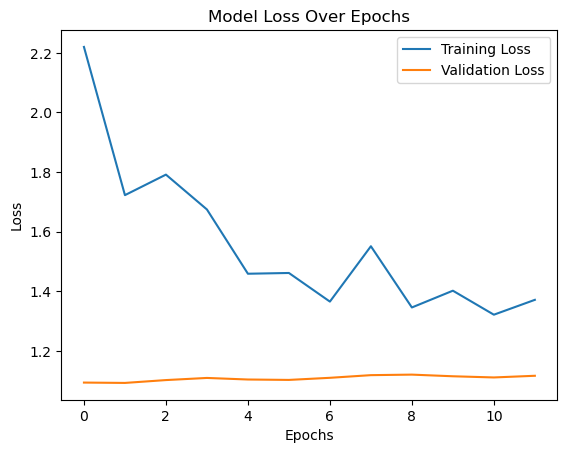

In [52]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [51]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 19s]
val_loss: 1.29628586769104

Best val_loss So Far: 1.29628586769104
Total elapsed time: 00h 20m 21s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size: 256


In [54]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0.0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model
    
# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 893ms/step - loss: 2.4649 - val_loss: 1.3547
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.4845 - val_loss: 1.3603
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.2292 - val_loss: 1.3551
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.1329 - val_loss: 1.3580
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.0442 - val_loss: 1.3563
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.1404 - val_loss: 1.3561
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9728 - val_loss: 1.3565
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.9467 - val_loss: 1.3579
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.6519 - val_loss: 1.3575
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.7180 - val_loss: 1.3488
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.7189 - val_loss: 1.3454
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.7486 - val

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step
LSTM Model Performance:
Training RMSE: 0.020301631867874283
Test RMSE: 0.023235272971684488
Training MAE: 0.014708270631894439
Test MAE: 0.0175777109707245
Directional Accuracy on Training Data: 60.25492468134415%
Directional Accuracy on Test Data: 58.45070422535211%


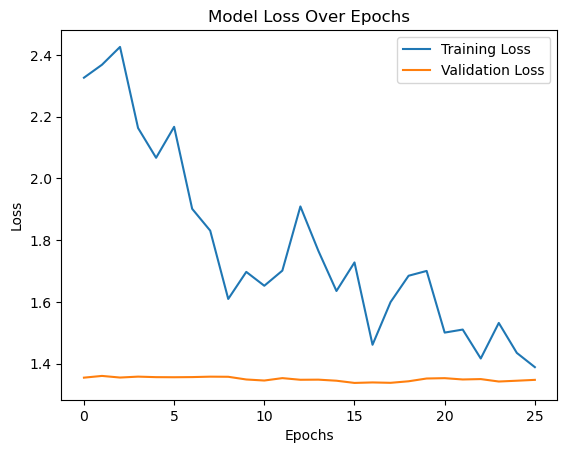

In [56]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation

In [18]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0012015897667654984,
    'epochs': 100,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fold 1 RMSE: 1.3948628511563586
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2 RMSE: 0.9487153376372921
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 RMSE: 0.7903071753664767
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 RMSE: 1.1338795872288432
Average RMSE from TSCV: 1.0669412378472427


In [19]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Rolling window RMSE: 1.282620163740682
Rolling window starting at index 50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Rolling window RMSE: 1.3822951600473827
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Rolling window RMSE: 0.9206345078136063
Rolling window starting at index 150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Rolling window RMSE: 0.7786881438478215
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Rolling window RMSE: 0.7884647796696848
Rolling window starting at index 250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Rolling window RMSE: 0.8946514305084446
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Rolling window RMSE: 0.8957477513949517
Rolling window starting at index 350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Rolling window RMSE: 0.45598799269557727
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step

In [20]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.027406534433443278
Descaled Validation Loss: 0.030066503759855562


In [21]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.02985033618861898, 0.02080376719515647, 0.0175917121557658, 0.024558357567833942]
Descaled FRWCV RMSE Values: [0.027574382193698486, 0.0295955001057972, 0.02023436995165307, 0.017356112119711272, 0.01755435375012812, 0.019707509004587478, 0.01972973919132668, 0.01081269521579795, 0.017927988845269516, 0.020692107386521247, 0.030165554220483143]
Average Descaled TSCV RMSE: 0.023201043276843795
Average Descaled FRWCV RMSE: 0.021031846544088562


### Model Performance Metrics for Sequence Length = 12

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       |
|-----------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.020357128   | 0.020397132   | 0.020418636   | 0.020301632   |
| **Test RMSE**  | 0.023259253   | 0.023255509   | 0.023153177   | 0.023235273   |
| **Train MAE**  | 0.01478992    | 0.014684571   | 0.014849      | 0.014708271   |
| **Test MAE**   | 0.017503574   | 0.017394277   | 0.017508652   | 0.017577711   |
| **Train Loss** | 1.210249424   | 1.410629749   | 1.371209502   | 1.388731122   |
| **Val Loss**   | 1.436954141   | 1.305546761   | 1.116409898   | 1.347561359   |
| **Train DA**   | 57%           | 52%           | 44%           | 60%           |
| **Test DA**    | 61%           | 48%           | 51%           | 58%           |

**The sequence length of 12 will be represented by the model 3**, the model outperfomed the others having lower test RMSE, lowest val loss and  the train loss "stabilized" faster than the others. 

#### Training and Validation Loss
| Metric           | Loss           |
|-------------------|----------------|
| **Training Loss** | 0.02740653     |
| **Validation Loss** | 0.03006650    |

#### TSCV RMSE Values
| Fold | RMSE           |
|------|----------------|
| 1    | 0.02985034     |
| 2    | 0.02080377     |
| 3    | 0.01759171     |
| 4    | 0.02455836     |

**Average TSCV RMSE**: **0.02320104**

- The model of SL = 12 has higher AVG RMSE than the SL =4, however the performance across all 4 folds remained the same, where not performs well on the first and last fold.

#### FRWCV RMSE Values
| Window | RMSE           |
|--------|----------------|
| 1      | 0.02757438     |
| 2      | 0.02959550     |
| 3      | 0.02023437     |
| 4      | 0.01735611     |
| 5      | 0.01755435     |
| 6      | 0.01970751     |
| 7      | 0.01972974     |
| 8      | 0.01081270     |
| 9      | 0.01792799     |
| 10     | 0.02069211     |
| 11     | 0.03016555     |

**Average FRWCV RMSE**: **0.02103185

- Observing the FRWCV scores, the avg is higher than the previous sequence length, altough it performs a little better throughtout the windows (Windown 10 performs below avg, where in the previous SL it performs above avg).

## Sequence Length = 26 

In [22]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 26  # Number of time steps used for target prediction, 26 weeks (Six-Months).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (850, 26, 5)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 5)
Reshaped  y_test_seq shape: (129, 1)


### 1. Random Search (Two Layers - Model 1)

In [59]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.08440101146698
Final Validation Loss: 1.333011507987976
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.9566689729690552
Final Validation Loss: 1.914771318435669
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.417626976966858
Final Validation Loss: 1.1555172204971313
Running combination 4/30:

In [64]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 314ms/step - loss: 3.2709 - val_loss: 1.2624
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.3829 - val_loss: 1.2699
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.1547 - val_loss: 1.2968
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.8948 - val_loss: 1.2821
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.8732 - val_loss: 1.2919
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.6473 - val_loss: 1.3073
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.6205 - val_loss: 1.3168
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.5031 - val_loss: 1.3299
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.3409 - val_loss: 1.3106
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2521 - val_loss: 1.3478
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.3521 - val_loss: 1.3381
Final Training Loss: 1.3900091648101807
Final Vali

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
LSTM Model Performance:
Training RMSE: 0.020564458094328397
Test RMSE: 0.024389697961093797
Training MAE: 0.014952567557523192
Test MAE: 0.018951863658739777
Directional Accuracy on Training Data: 51.23674911660777%
Directional Accuracy on Test Data: 53.90625%


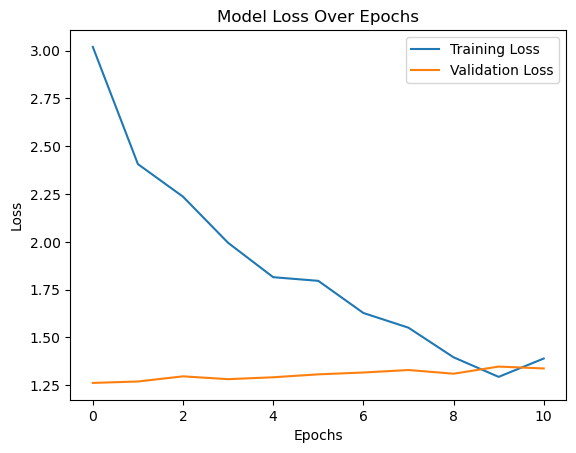

In [66]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [63]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0254290103912354
Final Validation Loss: 1.4330687522888184
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.140512466430664
Final Validation Loss: 4.019299507141113
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.6258623600006104
Final Valida

In [72]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 415ms/step - loss: 3.1402 - val_loss: 1.2735
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 2.2820 - val_loss: 1.2668
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 2.2671 - val_loss: 1.2600
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 1.9645 - val_loss: 1.2617
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1.9040 - val_loss: 1.2776
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1.7372 - val_loss: 1.2740
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 1.7018 - val_loss: 1.2745
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.9008 - val_loss: 1.3094
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 1.6994 - val_loss: 1.3156
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 1.7614 - val_loss: 1.3016
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 1.5000 - val_loss: 1.2623
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
LSTM Model Performance:
Training RMSE: 0.020469690681023
Test RMSE: 0.024201428827982176
Training MAE: 0.014876317775761804
Test MAE: 0.018582195647587972
Directional Accuracy on Training Data: 51.47232037691401%
Directional Accuracy on Test Data: 52.34375%


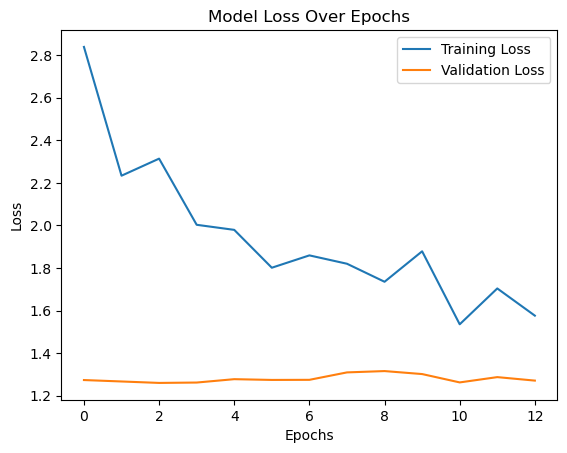

In [73]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [67]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 16:59:06,884] A new study created in memory with name: no-name-5821cb99-b769-460e-b735-05f89320d2be
[I 2024-11-13 16:59:34,262] Trial 0 finished with value: 1.4006462097167969 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.4006462097167969.
[I 2024-11-13 17:00:01,595] Trial 1 finished with value: 3.9783754348754883 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.4006462097167969.
[I 2024-11-13 17:02:15,458] Trial 2 finished with value: 4.7478485107421875 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0011454828358668492, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 0.9259576797485352


In [78]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0015394277020084359,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - loss: 2.2177 - val_loss: 0.9900
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.8427 - val_loss: 0.9936
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.8769 - val_loss: 0.9839
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.8284 - val_loss: 0.9773
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.8691 - val_loss: 0.9815
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.5748 - val_loss: 0.9895
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.4847 - val_loss: 0.9694
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.3739 - val_loss: 0.9772
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.3682 - val_loss: 0.9764
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.4446 - val_loss: 0.9812
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.2896 - val_loss: 0.9684
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
LSTM Model Performance:
Training RMSE: 0.020233155675107386
Test RMSE: 0.023801557089073846
Training MAE: 0.014721210001560682
Test MAE: 0.018203910611018784
Directional Accuracy on Training Data: 70.6713780918728%
Directional Accuracy on Test Data: 66.40625%


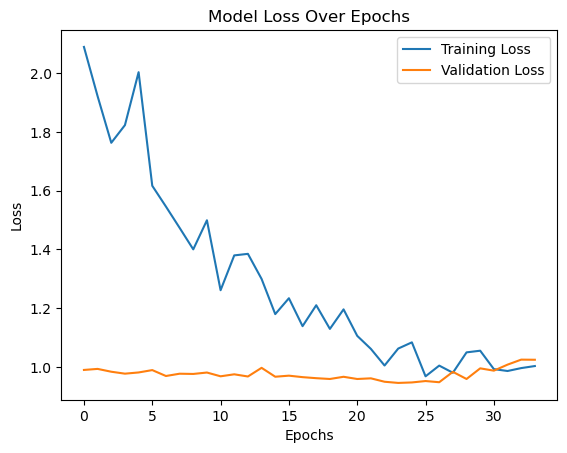

In [79]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [71]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 36s]
val_loss: 1.5710058212280273

Best val_loss So Far: 1.154745101928711
Total elapsed time: 00h 39m 05s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size: 256


In [82]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0.0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 2.4657 - val_loss: 1.4674
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 2.3210 - val_loss: 1.4640
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 2.0615 - val_loss: 1.4662
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 2.3965 - val_loss: 1.4636
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 1.9217 - val_loss: 1.4590
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 1.9861 - val_loss: 1.4656
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 1.8647 - val_loss: 1.4649
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 1.9412 - val_loss: 1.4670
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 1.8924 - val_loss: 1.4655
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 1.4930 - val_loss: 1.4564
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.0021 - val_loss: 1.4604
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 1.930

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.02035861579386718
Test RMSE: 0.024124869104101693
Training MAE: 0.014754933578243125
Test MAE: 0.018413920081660515
Directional Accuracy on Training Data: 64.78209658421673%
Directional Accuracy on Test Data: 65.625%


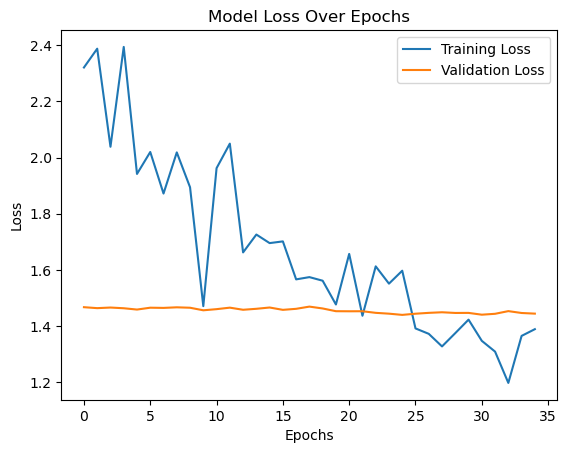

In [84]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation

In [28]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0015394277020084359,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fold 1 RMSE: 1.3981000581281835
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 2 RMSE: 0.9455451709022236
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 3 RMSE: 0.7547278175981055
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 4 RMSE: 1.1452680272723192
Average RMSE from TSCV: 1.060910268475208


In [29]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Rolling window RMSE: 1.0065762272284613
Rolling window starting at index 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Rolling window RMSE: 1.5270547035690634
Rolling window starting at index 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Rolling window RMSE: 0.9907231761037796
Rolling window starting at index 150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Rolling window RMSE: 0.7927440011460382
Rolling window starting at index 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Rolling window RMSE: 0.7674108035743965
Rolling window starting at index 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Rolling window RMSE: 0.9280452078696475
Rolling window starting at index 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Rolling window RMSE: 0.6022921650936036
Rolling window starting at index 350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Rolling window RMSE: 0.4216688307094885
Rolling window starting at index 400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

In [30]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.024038753940243462
Descaled Validation Loss: 0.03605486628160111


In [31]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.029915977294596992, 0.020739485469447937, 0.016870266658387943, 0.02478928188201106]
Descaled FRWCV RMSE Values: [0.021977017104319665, 0.03253080100572042, 0.021655563512378503, 0.01764112386797275, 0.017127440584501802, 0.02038463731236978, 0.01377931667960583, 0.010116802809593383, 0.017788730560564396, 0.014482044424293936, 0.03595164568634922]
Average Descaled TSCV RMSE: 0.023078752826110983
Average Descaled FRWCV RMSE: 0.020312283958879063


### Model Performance Metrics for Sequence Length = 26

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       |
|-----------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.020564458   | 0.020469691   | 0.020233156   | 0.020358616   |
| **Test RMSE**  | 0.024389698   | 0.024201429   | 0.023801557   | 0.024124869   |
| **Train MAE**  | 0.014952568   | 0.014876318   | 0.01472121    | 0.014754934   |
| **Test MAE**   | 0.018951864   | 0.018582196   | 0.018203911   | 0.01841392    |
| **Train Loss** | 1.390009165   | 1.575931907   | 1.003272176   | 1.389121532   |
| **Val Loss**   | 1.338090062   | 1.270840764   | 1.024671555   | 1.444473982   |
| **Train DA**   | 51%           | 51%           | 71%           | 65%           |
| **Test DA**    | 54%           | 52%           | 66%           | 66%           |

---

**Sequence Length of 26 has the model 3 the as the best performer**, it has the lowest metrics for all, but also the covergence between train and val loss is satisfatory. 


#### Training and Validation Loss
| Metric           | Loss           |
|-------------------|----------------|
| **Training Loss** | 0.02740653     |
| **Validation Loss** | 0.03006650    |

#### TSCV RMSE Values
| Fold | RMSE           |
|------|----------------|
| 1    | 0.02985034     |
| 2    | 0.02080377     |
| 3    | 0.01759171     |
| 4    | 0.02455836     |

**Average TSCV RMSE**: **0.02320104**

- When TSCV performed it shows similar results and observations as the previous SL.

#### FRWCV RMSE Values
| Window | RMSE           |
|--------|----------------|
| 1      | 0.02757438     |
| 2      | 0.02959550     |
| 3      | 0.02023437     |
| 4      | 0.01735611     |
| 5      | 0.01755435     |
| 6      | 0.01970751     |
| 7      | 0.01972974     |
| 8      | 0.01081270     |
| 9      | 0.01792799     |
| 10     | 0.02069211     |
| 11     | 0.03016555     |

**Average FRWCV RMSE**: **0.02103185**

- The FRWCV scores shows that it performs similar to the SL = 12, where underperforms in 3 windows (location start and ent windows is also the same).

## Sequence Length = 52

In [32]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 52  # Number of time steps used for target prediction, 52 weeks (One year).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (824, 52, 5)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 5)
Reshaped  y_test_seq shape: (103, 1)


### 1. Random Search (Two Layers - Model 1)

In [79]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.827374815940857
Final Validation Loss: 1.913159966468811
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.387868642807007
Final Validation Loss: 2.4169936180114746
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.6863856315612793
Final Validation Loss: 1.6620391607284546
Running combination 4/3

In [80]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 3.1337 - val_loss: 1.5933
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 2.8316 - val_loss: 1.5908
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 2.1631 - val_loss: 1.5929
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 2.0924 - val_loss: 1.5947
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 2.2323 - val_loss: 1.5880
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 1.9563 - val_loss: 1.5791
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 2.0527 - val_loss: 1.5853
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 1.7612 - val_loss: 1.5741
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 1.8068 - val_loss: 1.5764
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 1.6509 - val_loss: 1.5737
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 1.6012 - val_loss: 1.5837
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM Model Performance:
Training RMSE: 0.02044323666418032
Test RMSE: 0.025435926144176522
Training MAE: 0.014981374062431635
Test MAE: 0.020283158408491573
Directional Accuracy on Training Data: 64.27703523693803%
Directional Accuracy on Test Data: 54.90196078431373%


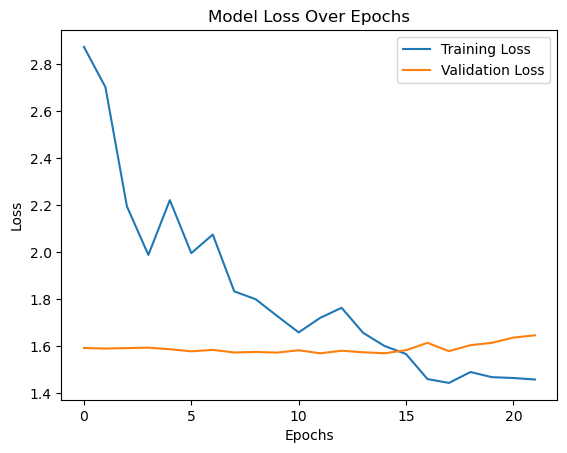

In [81]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [83]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0516377687454224
Final Validation Loss: 1.5555119514465332
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.183912754058838
Final Validation Loss: 4.299307823181152
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.960617780685425
Final Validat

In [92]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 489ms/step - loss: 3.1689 - val_loss: 1.7344
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 2.5636 - val_loss: 1.7160
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 2.2878 - val_loss: 1.7233
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 1.9459 - val_loss: 1.7226
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 2.0355 - val_loss: 1.7131
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 1.9846 - val_loss: 1.7165
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 1.8173 - val_loss: 1.7147
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 1.6447 - val_loss: 1.7143
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 1.7454 - val_loss: 1.7235
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 1.5846 - val_loss: 1.7022
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 1.6611 - val_loss: 1.7223
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
LSTM Model Performance:
Training RMSE: 0.021570579950971648
Test RMSE: 0.025544102735954748
Training MAE: 0.016092109581277908
Test MAE: 0.019771341407930246
Directional Accuracy on Training Data: 60.51032806804374%
Directional Accuracy on Test Data: 59.80392156862745%


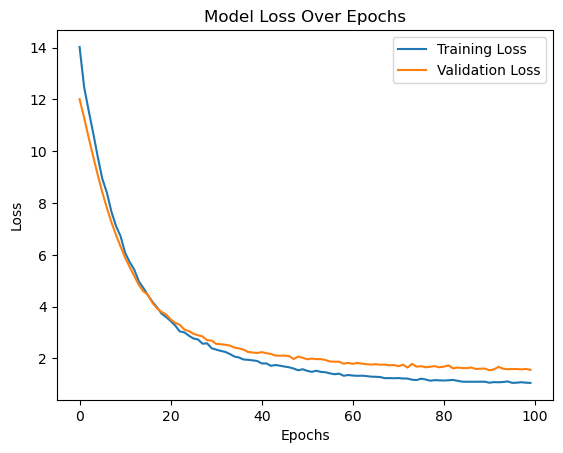

In [90]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [87]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.
    
    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 18:36:10,488] A new study created in memory with name: no-name-a1322880-430e-42fa-b9b2-7152897dc7a2
[I 2024-11-13 18:36:41,636] Trial 0 finished with value: 1.8467261791229248 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.8467261791229248.
[I 2024-11-13 18:37:20,929] Trial 1 finished with value: 4.110915184020996 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.8467261791229248.
[I 2024-11-13 18:42:27,231] Trial 2 finished with value: 5.081692218780518 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0019223481607694784, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 150, 'batch_size': 64}
Best validation loss: 1.3782212734222412


In [94]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0019223481607694784,
    'epochs': 150,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Select the loss function based on tuning results.
    if params['loss_function'] == 'huber_loss':
        loss = Huber()  # Huber loss is more robust to outliers
    else:
        loss = MeanSquaredError()  # Use MSE as default loss function for regression
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - loss: 1.8093 - val_loss: 1.4182
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 1.8499 - val_loss: 1.4358
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7074 - val_loss: 1.4256
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.7575 - val_loss: 1.4357
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.4206 - val_loss: 1.4333
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3772 - val_loss: 1.4295
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4498 - val_loss: 1.4258
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.3688 - val_loss: 1.4309
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3824 - val_loss: 1.4233
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3099 - val_loss: 1.4271
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3266 - val_loss: 1.4223
Final Training Loss: 1.3508981466293335
Final Vali

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Model Performance:
Training RMSE: 0.020614847674757793
Test RMSE: 0.025500470618167022
Training MAE: 0.014900086136902616
Test MAE: 0.019994078796736647
Directional Accuracy on Training Data: 59.05224787363304%
Directional Accuracy on Test Data: 70.58823529411765%


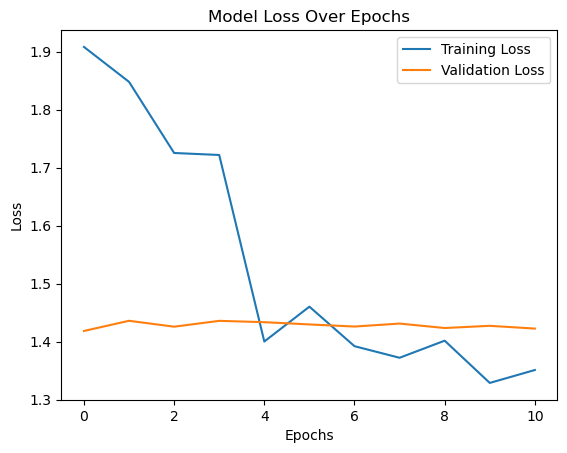

In [96]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [91]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 01m 18s]
val_loss: 1.7997627258300781

Best val_loss So Far: 1.374737024307251
Total elapsed time: 01h 08m 37s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.025064206402151706, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=120
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.025064206402151706, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 120}
Best batch size: 120


In [12]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.025064206402151706,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 7.9163 - val_loss: 4.4116
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 6.4532 - val_loss: 4.3938
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 6.1212 - val_loss: 4.3765
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 6.0312 - val_loss: 4.3566
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 5.6930 - val_loss: 4.3367
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5.5949 - val_loss: 4.3158
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 5.7923 - val_loss: 4.2937
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 5.4095 - val_loss: 4.2711
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.2570 - val_loss: 4.2481
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5.2420 - val_loss: 4.2246
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 5.1028 - val_loss: 4.1993
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 5.2086 - v

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Model Performance:
Training RMSE: 0.020201890867667695
Test RMSE: 0.025835920207775084
Training MAE: 0.014861967951629954
Test MAE: 0.02043284541149774
Directional Accuracy on Training Data: 53.94896719319563%
Directional Accuracy on Test Data: 50.98039215686274%


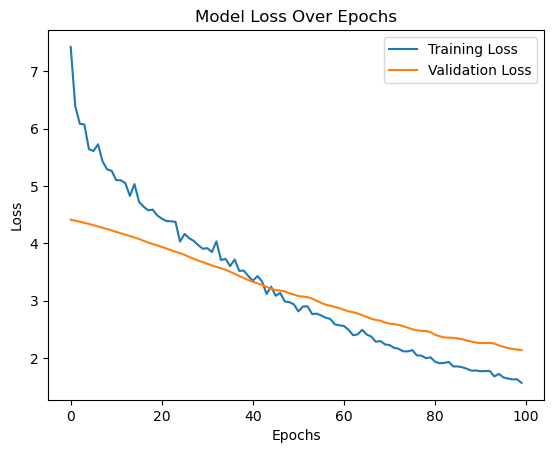

In [13]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross-Validation for the best model 

In [37]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0019223481607694784,
    'epochs': 150,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 1 RMSE: 1.4798433156674633
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 2 RMSE: 0.7653262631352602
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3 RMSE: 0.7561677292282575
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 4 RMSE: 1.1977075564449342
Average RMSE from TSCV: 1.0497612161189789


In [39]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 53    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Rolling window RMSE: 0.5848774968499016
Rolling window starting at index 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Rolling window RMSE: 0.49515099621999115
Rolling window starting at index 106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Rolling window RMSE: 0.3491962130026016
Rolling window starting at index 159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Rolling window RMSE: 0.023286622005266294
Rolling window starting at index 212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Rolling window RMSE: 0.8242264277418622
Rolling window starting at index 265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Rolling window RMSE: 0.5897786893246871
Rolling window starting at index 318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Rolling window RMSE: 0.21980296998516416
Rolling window starting at index 371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Rolling window RMSE: 0.17773687427233079
Rolling window starting at index 424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms

In [40]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.024312027947046056
Descaled Validation Loss: 0.07295831226156373


In [41]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.031573491898335485, 0.01708517219045974, 0.016899463862254244, 0.02585260243019221]
Descaled FRWCV RMSE Values: [0.013426198051817762, 0.011606806586228539, 0.008647269714920726, 0.002038774741290126, 0.01827949556264895, 0.013525579925592324, 0.006023552525482477, 0.005170574921393507, 0.01097493260140494, 0.07301275649577867]
Average Descaled TSCV RMSE: 0.022852682595310418
Average Descaled FRWCV RMSE: 0.0162705941126558


### Model Performance Metrics for Sequence Length = 52

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       |
|-----------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.020443237   | 0.02157058    | 0.020614848   | 0.020201891   |
| **Test RMSE**  | 0.025435926   | 0.025544103   | 0.025500471   | 0.02583592    |
| **Train MAE**  | 0.014981374   | 0.01609211    | 0.014900086   | 0.014861968   |
| **Test MAE**   | 0.020283158   | 0.019771341   | 0.019994079   | 0.020432845   |
| **Train Loss** | 1.459251523   | 1.30606246    | 1.350898147   | 1.567188859   |
| **Val Loss**   | 1.64723587    | 1.789971828   | 1.422319174   | 2.139624119   |
| **Train DA**   | 64%           | 61%           | 59%           | 54%           |
| **Test DA**    | 55%           | 60%           | 71%           | 51%           |

**The best performer for the sequence length of 52 is  the model 3**, having one of the lowest metrics of all models and its train and val loss plot shows more stability than the others. 

### Evaluation Metrics

#### Training and Validation Loss
| Metric           | Loss           |
|-------------------|----------------|
| **Training Loss** | 0.02403875     |
| **Validation Loss** | 0.03605487    |

#### TSCV RMSE Values
| Fold | RMSE           |
|------|----------------|
| 1    | 0.02991598     |
| 2    | 0.02073949     |
| 3    | 0.01687027     |
| 4    | 0.02478928     |

**Average TSCV RMSE**: **0.02307875**

- The SL = 52 has same performance as the others SL. Thus, despite different sequence length and acrchitectures the technology underperforms at the start and at the end. 

## Evaluation

## LSTM - Standard Scaling Performance Metrics

| Metrics        | SL = 4         | SL = 12         | SL = 26         | SL = 52         |
|-----------------|----------------|-----------------|-----------------|-----------------|
| **Train RMSE** | 0.020128678    | 0.020418636     | 0.020233156     | 0.020614848     |
| **Test RMSE**  | 0.022446095    | 0.023153177     | 0.023801557     | 0.025500471     |
| **Train MAE**  | 0.014421072    | 0.014849        | 0.01472121      | 0.014900086     |
| **Test MAE**   | 0.016954642    | 0.017508652     | 0.018203911     | 0.019994079     |
| **Train Loss** | 0.89046818     | 1.371209502     | 1.003272176     | 1.350898147     |
| **Val Loss**   | 1.31695807     | 1.116409898     | 1.024671555     | 1.422319174     |
| **Avg RMSE - TSCV** | 1.049797895 | 1.065019938     | 1.05921564      | 1.050389102     |
| **Avg RMSE - FRWCV** | 0.92217397  | 0.944819762     | 0.929217867     | 0.704554111     |
| **Train DA**   | 63%            | 44%             | 71%             | 59.00%          |
| **Test DA**    | 59%            | 51%             | 66%             | 71.00%          |

---

#### Training and Validation Loss
| Sequence Length (SL) | Training Loss | Validation Loss |
|-----------------------|---------------|-----------------|
| **SL = 4**                | 0.02419945    | 0.02866454      |
| **SL = 12**               | 0.02740653    | 0.03006650      |
| **SL = 26**               | 0.02740653    | 0.03006650      |
| **SL = 52**               | 0.02403875    | 0.03605487      |

---

#### TSCV RMSE Comparison
| Sequence Length (SL) | Fold 1 RMSE | Fold 2 RMSE | Fold 3 RMSE | Fold 4 RMSE | Average TSCV RMSE |
|-----------------------|-------------|-------------|-------------|-------------|-------------------|
| **SL = 4**           | 0.02949634  | 0.02064368  | 0.01744158  | 0.02371384  | **0.02282386**    |
| **SL = 12**          | 0.02985034  | 0.02080377  | 0.01759171  | 0.02455836  | **0.02320104**    |
| **SL = 26**          | 0.02985034  | 0.02080377  | 0.01759171  | 0.02455836  | **0.02320104**    |
| **SL = 52**          | 0.02991598  | 0.02073949  | 0.01687027  | 0.02478928  | **0.02307875**    |

---

#### FRWCV RMSE Comparison
| Sequence Length (SL) | Window 1 RMSE | Window 2 RMSE | Window 3 RMSE | Window 4 RMSE | Window 5 RMSE | Window 6 RMSE | Window 7 RMSE | Window 8 RMSE | Window 9 RMSE | Window 10 RMSE | Window 11 RMSE | Average FRWCV RMSE |
|-----------------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|----------------|----------------|-------------------|
| **SL = 4**           | 0.02596537    | 0.02702303    | 0.01925910    | 0.01631107    | 0.01668102    | 0.01931634    | 0.01828439    | 0.01194746    | 0.01683637    | 0.02289894     | 0.02835240     | **0.02026141**    |
| **SL = 12**          | 0.02757438    | 0.02959550    | 0.02023437    | 0.01735611    | 0.01755435    | 0.01970751    | 0.01972974    | 0.01081270    | 0.01792799    | 0.02069211     | 0.03016555     | **0.02103185**    |
| **SL = 26**          | 0.02757438    | 0.02959550    | 0.02023437    | 0.01735611    | 0.01755435    | 0.01970751    | 0.01972974    | 0.01081270    | 0.01792799    | 0.02069211     | 0.03016555     | **0.02103185**    |

### Best Model: Sequence Length = 4.

The LSTM model that yielded the best balanced performance was the sequence length of 4 (approx. One Month), having the lowest RMSE and MAE scores. Cross validation also shows that all sequences are generalizing well across different folds. 
In addition, by observing the cross-validation table, it shows that the SL = 4, is more stable across different periods. It performed well on both TSCV and FRWCV.